In [58]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

import warnings
warnings.filterwarnings("ignore")

In [2]:
path = '../data/'

users = pd.read_csv(path + 'users.csv')
books = pd.read_csv(path + 'books.csv')
train = pd.read_csv(path + 'train_ratings.csv')
test = pd.read_csv(path + 'test_ratings.csv')
print(users.shape)
print(books.shape)
print(train.shape)
print(test.shape)

(68092, 3)
(149570, 10)
(306795, 3)
(76699, 3)


# Train, Test 데이터 탐색

In [15]:
_data = pd.concat([train, test])
_user = _data['user_id'].nunique()
_book = _data['isbn'].nunique()
data_cnt = len(train)

_matrix = np.round((1 - data_cnt/(_user*_book)) * 100, 5)

print(f'전체 데이터에 유저는 {_user}명, 책은 {_book}개 존재하고 평점 기록은 {data_cnt}개 존재합니다.')
print(f'유저와 책 간 평점 행렬을 모두 채우려면 {_user*_book}개가 필요합니다.')
print(f'현재 있는 평점 기록은 {data_cnt}이므로 {_matrix}%만큼 희소행렬 입니다.')
print('유저와 책 수 대비 평점 기록 데이터가 상당히 많이 부족합니다.')
print('MF모델이나 딥러닝 모델 적용하기 쉽지 않아보입니다.')

전체 데이터에 유저는 68069명, 책은 149570개 존재하고 평점 기록은 306795개 존재합니다.
유저와 책 간 평점 행렬을 모두 채우려면 10181080330개가 필요합니다.
현재 있는 평점 기록은 306795이므로 99.99699%만큼 희소행렬 입니다.
유저와 책 수 대비 평점 기록 데이터가 상당히 많이 부족합니다.
MF모델이나 딥러닝 모델 적용하기 쉽지 않아보입니다.


In [25]:
print('트레인 데이터 내 최다 독서 유저 5명의 리스트 입니다.')
print(train['user_id'].value_counts()[:5])
print('')
print('테스트 데이터 내 최다 독서 유저 5명의 리스트 입니다.')
print(test['user_id'].value_counts()[:5])
print('')
print('트레인과 테스트 데이터 구성이 거의 동일한 것으로 보이는데요. 전체 데이터 셋에서 랜덤하게 분류한 것 같습니다.')
print('즉, 트레인 데이터의 일부를 valid로 사용한다면 테스트 데이터 환경과 유사하다는 생각을 얻었습니다.')
print('시간적 요소를 고려하지 않아 실제 추천시스템 환경과는 거리가 있다는 것을 계속 고려해야겠습니다.')

트레인 데이터 내 최다 독서 유저 5명의 리스트 입니다.
11676     5520
98391     4560
189835    1503
153662    1496
23902      956
Name: user_id, dtype: int64

테스트 데이터 내 최다 독서 유저 5명의 리스트 입니다.
11676     1419
98391     1125
189835     396
153662     347
23902      223
Name: user_id, dtype: int64

트레인과 테스트 데이터 구성이 거의 동일한 것으로 보이는데요. 전체 데이터 셋에서 랜덤하게 분류한 것 같습니다.
즉, 트레인 데이터의 일부를 valid로 사용한다면 테스트 데이터 환경과 유사하다는 생각을 얻었습니다.
시간적 요소를 고려하지 않아 실제 추천시스템 환경과는 거리가 있다는 것을 계속 고려해야겠습니다.


In [28]:
def rmse(real: list, predict: list) -> float:
    pred = np.array(predict)
    return np.sqrt(np.mean((real-pred) ** 2))

_rmse = np.round(rmse(train['rating'], train['rating'].mean()),4)

print(f'레이팅의 평균 값을 예측에 사용했을 때 RMSE 값은 {_rmse} 입니다.')
print('이 수치는 추천 시스템 모델을 평가할 때에 기준점으로 사용할 수 있습니다.')

레이팅의 평균 값을 예측에 사용했을 때 RMSE 값은 2.4332 입니다.
이 수치는 추천 시스템 모델을 평가할 때에 기준점으로 사용할 수 있습니다.


# User 테이블 탐색

In [27]:
user_sum = pd.concat([train, test])['user_id'].nunique()
test_user = test['user_id'].nunique()
test_user_only = len(set(test['user_id']) - set(train['user_id']))
print(f'전체 유저 {user_sum}명에서 test 테이터 유저 {test_user}명중 train 데이터에 존재하지 않는 유저는 {test_user_only}명 입니다.')
print('즉 cold start 문제가 자주 발생하는 데이터 입니다.')

전체 유저 68069명에서 test 테이터 유저 26167명중 train 데이터에 존재하지 않는 유저는 8266명 입니다.
즉 cold start 문제가 자주 발생하는 데이터 입니다.


In [34]:
users['location'] = users['location'].str.replace(r'[^0-9a-zA-Z:,]', '') # 특수문자 제거

users['location_city'] = users['location'].apply(lambda x: x.split(',')[0].strip())
users['location_state'] = users['location'].apply(lambda x: x.split(',')[1].strip())
users['location_country'] = users['location'].apply(lambda x: x.split(',')[2].strip())

users = users.replace('na', np.nan) #특수문자 제거로 n/a가 na로 바뀌게 되었습니다. 따라서 이를 컴퓨터가 인식할 수 있는 결측값으로 변환합니다.
users = users.replace('', np.nan) # 일부 경우 , , ,으로 입력된 경우가 있었으므로 이런 경우에도 결측값으로 변환합니다.

modify_location = users[(users['location_country'].isna())&(users['location_city'].notnull())]['location_city'].values
location = users[(users['location'].str.contains('seattle'))&(users['location_country'].notnull())]['location'].value_counts().index[0]

location_list = []
for location in modify_location:
    try:
        right_location = users[(users['location'].str.contains(location))&(users['location_country'].notnull())]['location'].value_counts().index[0]
        location_list.append(right_location)
    except:
        pass

for location in location_list:
    users.loc[users[users['location_city']==location.split(',')[0]].index,'location_state'] = location.split(',')[1]
    users.loc[users[users['location_city']==location.split(',')[0]].index,'location_country'] = location.split(',')[2]

loc_city2idx = {v:k for k,v in enumerate(users['location_city'].unique())}
loc_state2idx = {v:k for k,v in enumerate(users['location_state'].unique())}
loc_country2idx = {v:k for k,v in enumerate(users['location_country'].unique())}

users['location_city'] = users['location_city'].map(loc_city2idx)
users['location_state'] = users['location_state'].map(loc_state2idx)
users['location_country'] = users['location_country'].map(loc_country2idx)

print('location 변수를 간단히 전처리 하여 city, state, country로 분할했습니다.')
print('')
print(users.drop(['location'], axis = 1).nunique())
print('')
print('User 변수 별 항목 개수 입니다.')

/tmp/ipykernel_50971/2697785152.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  users['location'] = users['location'].str.replace(r'[^0-9a-zA-Z:,]', '') # 특수문자 제거


location 변수를 간단히 전처리 하여 city, state, country로 분할했습니다.

user_id             68092
age                    91
location_city       11995
location_state       1324
location_country      269
dtype: int64

User 변수 별 항목 개수 입니다.


In [47]:
print('나이 그룹 별 평점 평균을 알아보겠습니다.')
print('')
user_rating = pd.merge(train,users, how='right',on='user_id')
user_rating.dropna(subset=['rating'], inplace = True)
pred = 0
for i in [10, 20, 30, 40, 50, 100]:
    tem = user_rating['rating'][(user_rating['age'] < i) & (user_rating['age'] > pred)]
    _mean = tem.mean()
    cnt =  len(tem)
    print(f'{pred} ~ {i} 까지 출판된 책 {cnt} 개의 평균 평점은 {np.round(_mean,4)} 입니다.')
    pred = i

tem = user_rating['rating'][user_rating['age'].isna()]
_mean = tem.mean()
cnt = tem.count()
print(f'NULL 나이 책은 {cnt}개로 평균 평점은 {np.round(_mean,4)} 입니다.')
print('')
print('나이 그룹 별 평점이 꽤 유의미하게 차이가 납니다.')

나이 그룹 별 평점 평균을 알아보겠습니다.

0 ~ 10 까지 출판된 책 623 개의 평균 평점은 6.7335 입니다.
10 ~ 20 까지 출판된 책 12034 개의 평균 평점은 7.1113 입니다.
20 ~ 30 까지 출판된 책 53141 개의 평균 평점은 7.2486 입니다.
30 ~ 40 까지 출판된 책 59784 개의 평균 평점은 7.0632 입니다.
40 ~ 50 까지 출판된 책 38489 개의 평균 평점은 7.2613 입니다.
50 ~ 100 까지 출판된 책 33299 개의 평균 평점은 7.3867 입니다.
NULL 나이 책은 92662개로 평균 평점은 6.7354 입니다.

나이 그룹 별 평점이 꽤 유의미하게 차이가 납니다.


# Book 테이블 탐색

In [39]:
print(books.info())
print('')
print('language 변수와 category 변수 그리고 summary 변수는 결측값이 약 40%정도 있습니다.')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149570 entries, 0 to 149569
Data columns (total 10 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   isbn                 149570 non-null  object 
 1   book_title           149570 non-null  object 
 2   book_author          149570 non-null  object 
 3   year_of_publication  149570 non-null  float64
 4   publisher            149570 non-null  object 
 5   img_url              149570 non-null  object 
 6   language             82343 non-null   object 
 7   category             80719 non-null   object 
 8   summary              82343 non-null   object 
 9   img_path             149570 non-null  object 
dtypes: float64(1), object(9)
memory usage: 11.4+ MB
None

language 변수와 category 변수 그리고 summary 변수는 결측값이 약 40%정도 있습니다.


In [48]:
print('책 출간 연도 그룹 별 평점 평균을 알아보겠습니다.')
print('')

book_rating = pd.merge(train,books, how='right',on='isbn')
book_rating.dropna(subset=['rating'], inplace = True)
book_rating['year_of_publication'][book_rating['year_of_publication'] < 1900] = 1900
pred = 1900
for i in [1970, 1980, 1990, 2000, 2020]:
    tem = book_rating['rating'][(book_rating['year_of_publication'] < i) & (book_rating['year_of_publication'] > pred)]
    _mean = tem.mean()
    cnt =  len(tem)
    print(f'{pred} ~ {i} 까지 출판된 책 {cnt} 개의 평균 평점은 {np.round(_mean,4)} 입니다.')
    pred = i

print('')
print('책 출간 연도 그룹 별 평점이 꽤 유의미하게 차이가 납니다.')

책 출간 연도 그룹 별 평점 평균을 알아보겠습니다.

1900 ~ 1970 까지 출판된 책 2469 개의 평균 평점은 7.5055 입니다.
1970 ~ 1980 까지 출판된 책 7208 개의 평균 평점은 7.2278 입니다.
1980 ~ 1990 까지 출판된 책 36409 개의 평균 평점은 7.0839 입니다.
1990 ~ 2000 까지 출판된 책 140308 개의 평균 평점은 7.0004 입니다.
2000 ~ 2020 까지 출판된 책 87570 개의 평균 평점은 7.1678 입니다.

책 출간 연도 그룹 별 평점이 꽤 유의미하게 차이가 납니다.


In [53]:
print('책 작성 언어 별 평점 평균 비교입니다.')

en_mean = np.round(book_rating['rating'][book_rating['language'] != 'en'].mean(), 4)
non_en_mean = np.round(book_rating['rating'][book_rating['language'] == 'en'].mean(), 4)
non_mean = np.round(book_rating['rating'][book_rating['language'].isna()].mean(), 4)
print(f'영어로 작성된 책의 평점 평균은 {en_mean} 입니다.')
print(f'영어로 작성하지 않은 책의 평점 평균은 {non_en_mean} 입니다.')
print(f'책 작성 언어가 NULL인 책의 평점 평균은 {non_mean} 입니다.')

책 작성 언어 별 평점 평균 비교입니다.
영어로 작성된 책의 평점 평균은 7.0414 입니다.
영어로 작성하지 않은 책의 평점 평균은 7.0891 입니다.
책 작성 언어가 NULL인 책의 평점 평균은 7.0485 입니다.


# 전반적인 데이터 분포

변수 별로 평점이 기록된 책의 개수를 나타낸 그래프입니다.
특별히 많이 추출된 일부 값이 존재하는 것을 알 수 있습니다.


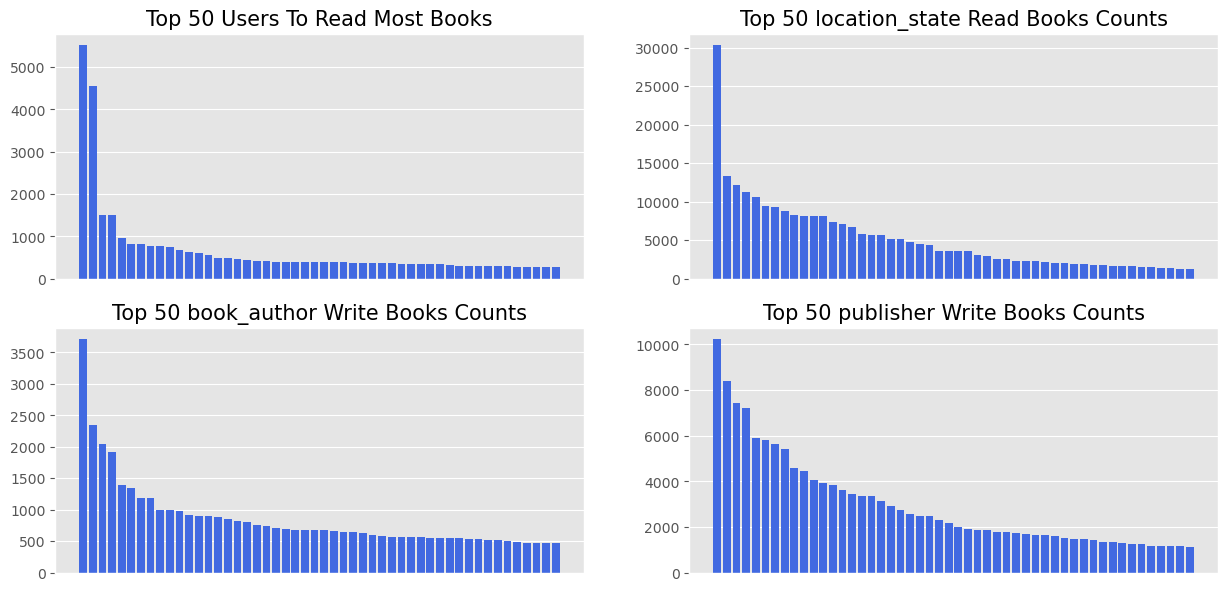

In [87]:
mpl.style.use('ggplot')
fig, axes = plt.subplots(2, 2, figsize=(15, 7))

axes[0][0].set_title('Top 50 Users To Read Most Books', fontsize=15)
axes[0][0].bar(np.arange(1,51,1), user_rating['user_id'].value_counts()[:50], color='royalblue')
axes[0][0].get_xaxis().set_visible(False)

axes[0][1].set_title('Top 50 location_state Read Books Counts', fontsize=15)
axes[0][1].bar(np.arange(1,51,1), user_rating['location_state'].value_counts()[:50], color='royalblue')
axes[0][1].get_xaxis().set_visible(False)

axes[1][0].set_title('Top 50 book_author Write Books Counts', fontsize=15)
axes[1][0].bar(np.arange(1,51,1), book_rating['book_author'].value_counts()[:50], color='royalblue')
axes[1][0].get_xaxis().set_visible(False)

axes[1][1].set_title('Top 50 publisher Write Books Counts', fontsize=15)
axes[1][1].bar(np.arange(1,51,1), book_rating['publisher'].value_counts()[:50], color='royalblue')
axes[1][1].get_xaxis().set_visible(False)

print('변수 별로 평점이 기록된 책의 개수를 나타낸 그래프입니다.')
print('특별히 많이 추출된 일부 값이 존재하는 것을 알 수 있습니다.')